# zprof

* Pre-calculated vertical profiles are stored to the ascii table with an extention ".zprof"
    * horizontal integrated variables are stored
    $$ \langle q \rangle_p \equiv \sum_{i,j} q \Theta(p) \Delta x \Delta y $$
    * for "horizontal average", proper normalization should be taken
* "zprof" files are stitched (if they were dumped from each processors) and merged (along t)
* Merged files can be found under the directory "zprof_merged/"

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import astropy
import cPickle as p
import glob

#### For example, data files for "MHD_4pc_new" model are

In [3]:
base='/tigress/changgoo/'
problem_id='MHD_4pc_new'

### To handle the multidimensional, labeled data, we use [xarray](https://xarray.pydata.org/en/stable/why-xarray.html) (instead of pandas Panel, which is [deprecated](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#deprecate-panel))

In [4]:
# This is a script to create the merged DataArrays for each phase and store them in the NetCDF format
def merge_to_xarray(base,problem_id):
    
    plist=['phase1','phase2','phase3','phase4','phase5','whole']
    for phase in plist:
        zprof_fnames=glob.glob('{}{}/zprof/{}.*.{}.zprof'.format(base,problem_id,problem_id,phase))
        zprof_fnames.sort()

        taxis=[]
        dfall=None
        for f in zprof_fnames:
            fp=open(f,'r')
            hd=fp.readline()
            fp.close()
            time=float(hd[hd.rfind('t=')+2:])
            df=pd.read_csv(f,skiprows=1)
            zaxis=np.array(df['z'])
            fields=np.array(df.columns)
            taxis.append(time)
            if dfall is None:
                dfall=np.array(df)[np.newaxis,:]
            else:
                dfall=np.concatenate([dfall,np.array(df)[np.newaxis,:]],axis=0)
    
        da=xr.DataArray(dfall.T,coords={'fields':fields,'zaxis':zaxis,'taxis':taxis},
                                dims=('fields','zaxis','taxis'))
        zpfile='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        da.to_netcdf(zpfile)
        print('{} is created'.format(zpfile))

In [5]:
import os
if not os.path.isfile('{}{}/zprof_merged/{}.whole.zprof.nc'.format(base,problem_id,problem_id)):
    zpdir='{}{}/zprof_merged/'.format(base,problem_id)
    if not os.path.isdir(zpdir): os.mkdir(zpdir)
    merge_to_xarray(base,problem_id)

In [6]:
zprof_fnames=glob.glob('{}{}/zprof_merged/{}.*.zprof.nc'.format(base,problem_id,problem_id))

In [7]:
zprof_fnames.sort()
zprof_fnames

['/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase1.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase2.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase3.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase4.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase5.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.whole.zprof.nc']

#### Data can be loaded with xarray.open_dataarray function
Note that the data is always loaded **lazily** from netCDF files. This is useful when one is working with a gigantic data. For our purpose, it is better to load data into memory. To do this, you may need to **load** it and **close** the file. 

In [8]:
data=xr.open_dataarray(zprof_fnames[-1])
data.load()
data.close()

In [9]:
data

<xarray.DataArray (fields: 85, zaxis: 1792, taxis: 702)>
array([[[ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        ...,
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06]],

       [[ 0.000000e+00,  1.889327e+01, ..., -3.905239e+04, -2.997081e+04],
        [ 0.000000e+00,  2.635888e+01, ..., -3.846292e+04, -3.023447e+04],
        ...,
        [ 0.000000e+00,  1.178177e+01, ..., -2.101226e+04, -2.481318e+04],
        [ 0.000000e+00,  9.267621e+00, ..., -2.139508e+04, -2.430190e+04]],

       ...,

       [[ 3.129800e+07,  3.067498e+07, ...,  2.730289e+06,  5.671139e+06],
        [ 3.129800e+07,  3.062639e+07, ...,  2.704058e+06,  5.793081e+06],
        ...,
        [ 3.129800e+07,  3.066132e+07, ...,  2.180871e+07,  1.938320e+07],
        [ 3.129800e+07,  3.070929e+07, ...,  2.199950e+07,  1.

In [10]:
# if you prefer, you can simply convert it into 3D array
print np.array(data).shape
# or select one item and convert it into 2D array
print np.array(data.sel(fields='d')).shape

(85, 1792, 702)
(1792, 702)


#### You can still access data as numpy.ndarray, but there are more (better) options for selecting and indexing data. Please read [xarray documentation](https://xarray.pydata.org/en/stable/indexing.html)

In [11]:
data.taxis.data

array([  0.      ,   1.000241,   2.005074,   3.003641,   4.007472,
         5.003506,   6.009704,   7.003821,   8.00585 ,   9.007101,
        10.00655 ,  11.00963 ,  12.00671 ,  13.00687 ,  14.00842 ,
        15.00462 ,  16.00866 ,  17.00657 ,  18.00156 ,  19.0033  ,
        20.00398 ,  21.00197 ,  22.00388 ,  23.0057  ,  24.00057 ,
        25.00464 ,  26.00767 ,  27.00134 ,  28.00741 ,  29.00504 ,
        30.00117 ,  31.00171 ,  32.00013 ,  33.00302 ,  34.00501 ,
        35.00518 ,  36.00339 ,  37.00144 ,  38.00159 ,  39.00123 ,
        40.00466 ,  41.00727 ,  42.00409 ,  43.00079 ,  44.00268 ,
        45.0004  ,  46.00134 ,  47.00168 ,  48.00078 ,  49.00091 ,
        50.00043 ,  51.00059 ,  52.00209 ,  53.00011 ,  54.00089 ,
        55.00152 ,  56.00097 ,  57.00115 ,  58.00034 ,  59.00007 ,
        60.00136 ,  61.00001 ,  62.00019 ,  63.00063 ,  64.00064 ,
        65.      ,  66.00033 ,  67.00085 ,  68.00025 ,  69.00059 ,
        70.00002 ,  71.00064 ,  72.0002  ,  73.00079 ,  74.000

In [12]:
data.fields[2]

<xarray.DataArray 'fields' ()>
array('B2', dtype='|S9')
Coordinates:
    fields   |S9 'B2'

In [13]:
# for example, to select 'density' at t=100
data[2,:,100]

<xarray.DataArray (zaxis: 1792)>
array([-3804.825293, -3868.679564, -3870.110196, ...,  -641.565313,
       -1155.022547, -1424.121891])
Coordinates:
    fields   |S9 'B2'
    taxis    float64 100.0
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...

In [14]:
# To use label, use "loc" or "sel" method
data.loc['d'][:,100]

<xarray.DataArray (zaxis: 1792)>
array([60.119443, 59.930423, 59.954811, ..., 40.954162, 40.78327 , 40.833619])
Coordinates:
    fields   |S1 'd'
    taxis    float64 100.0
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...

In [15]:
data.sel(fields='d')[:,100]

<xarray.DataArray (zaxis: 1792)>
array([60.119443, 59.930423, 59.954811, ..., 40.954162, 40.78327 , 40.833619])
Coordinates:
    fields   |S1 'd'
    taxis    float64 100.0
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...

In [16]:
# For "loc" or "sel" method, the label asked should exactly match with the values in the axis.
# For example, since there is no zaxis=0, following command will return an error

#data.loc['d',0,:]

In [17]:
print data.fields

<xarray.DataArray 'fields' (fields: 85)>
array(['A', 'B1', 'B2', 'B3', 'Ber', 'Ek1', 'Ek2', 'Ek3', 'M1', 'M2', 'M3',
       'MxyL', 'MxyR', 'P', 'PB1', 'PB2', 'PB3', 'Phie', 'Phisg', 'RxyL',
       'RxyR', 'S1', 'S2', 'S3', 'T', 'cool', 'd', 'dB1', 'dB2', 'dB3', 'dEk2',
       'dM2', 'dPB1', 'dPB2', 'dPB3', 'dWext', 'dWsg', 'dvA1', 'dvA2', 'dvA3',
       'gext', 'gsg', 'heat', 'mA', 'mFzE1', 'mFzE2', 'mFzE3', 'mFzEge',
       'mFzEgsg', 'mFzEtidal', 'mFzM1', 'mFzM2', 'mFzM3', 'mFzP', 'mFzd',
       'mSzEm1', 'mSzEm2', 'mSzvB1', 'mSzvB2', 'md', 'mvz', 'pA', 'pFzE1',
       'pFzE2', 'pFzE3', 'pFzEge', 'pFzEgsg', 'pFzEtidal', 'pFzM1', 'pFzM2',
       'pFzM3', 'pFzP', 'pFzd', 'pSzEm1', 'pSzEm2', 'pSzvB1', 'pSzvB2', 'pd',
       'pvz', 'v1', 'v2', 'v3', 'vA1', 'vA2', 'vA3'], dtype='|S9')
Coordinates:
  * fields   (fields) |S9 'A' 'B1' 'B2' 'B3' 'Ber' 'Ek1' 'Ek2' 'Ek3' 'M1' ...


## Variables in zprof data
* All variables use conventional nomenclature, and are in code units
* v2, dM2, dEk2 used perturbed y-velocity (substracted $v_{y0}=-q \Omega x$)
* T is calculated correctly in unit of K with temperature dependent $\mu$
* Phie is the external gravitational potential, defined w.r.t the midplane
* Phisg is the self gravitational potential, defined w.r.t the z-boundaries
* gext and gsg are gravitational acceleration calculated by the centered difference
* dW(ext/sg) = d*g(ext/sg)
* Ber is the Bernoulli parameter (may have a problem since the grav. potentials are not defined with the same reference)
* cool = $\langle n^2\Lambda(T)\rangle$ and heat = $\langle n\Gamma \rangle$
* dB, dPB, and dvA are from "turbulent" magnetic fields
* S(1/2/3) is the poynting flux in each direction
* s(1/2/3) is the passive scalar (not included in some simulations)
* variables start with "p" and "m" are fluxes with "plus" and "minus" vertical velocities, respectively
* Poynting flux is decomposed into 4 terms,
    * p/mSz=p/m(SzEm1+SzEm2+SzvB1+SzvB2)
$$S_z = B_x^2v_z + B_y^2 v_z -B_z B_x v_x - B_z B_y v_y$$
* Rxy(L/R) and Mxy(L/R) are Reynolds and Maxwell stresses calculated at left and right boundaries

#### Example 1: (t,z) images

In [18]:
data.sel(fields='d').shape

(1792, 702)

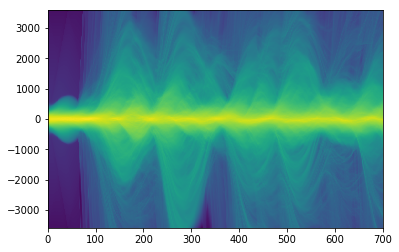

In [19]:
from matplotlib.colors import LogNorm,SymLogNorm,Normalize
z=data.zaxis
t=data.taxis
Lx=max(z)-min(z)
trange=max(t)-min(t)
plt.imshow(data.loc['d'],norm=LogNorm(),origin='lower',
           extent=[min(t),max(t),min(z),max(z)],aspect='auto')

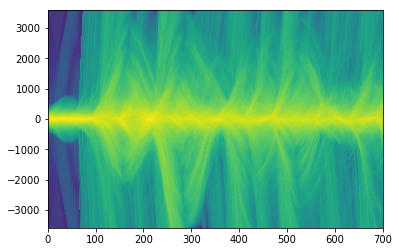

In [20]:
# net outgoing mass flux
plt.imshow(data.loc['pFzd']-data.loc['mFzd'],norm=LogNorm(),origin='lower',
           extent=[min(t),max(t),min(z),max(z)],aspect='auto')

#### Example 2: time averaged profiles

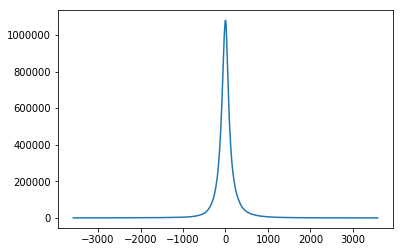

In [21]:
# simple time average for entire period 
dmean = data.loc['d'].mean(axis=1)
plt.plot(z,dmean)

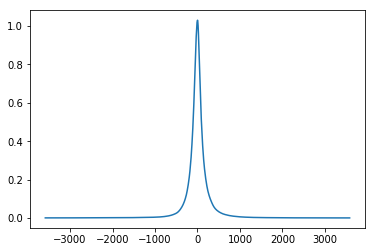

In [22]:
# note that each data is not normalized by its area. Therefore, you need to calculate "area"
Amean = data.loc['A'].mean(axis=1)
plt.plot(z,dmean/Amean)

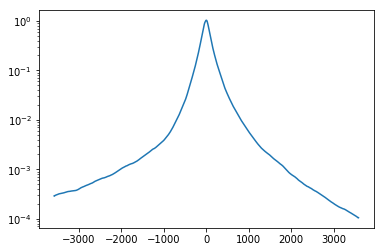

In [23]:
# or you may be able to devide area first
dmean2 = (data.loc['d']/data.loc['A']).mean(axis=1)
plt.semilogy(z,dmean2)

dz = <xarray.DataArray 'zaxis' ()>
array(4.) pc


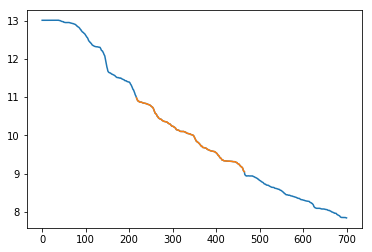

In [24]:
# time average for a selected time
import pyathena as pa
units=pa.set_units(muH=1.4271)
surf_unit=(units['density']*units['length']).to('Msun/pc^2')
dz=z[1]-z[0]
print('dz = {} pc'.format(dz))
surf=(data.loc['d']/data.loc['A']).sum(axis=0)*surf_unit*dz
plt.plot(data.taxis,surf)

trange=(surf>9) & (surf <11)
data_selected=data[:,:,trange]

plt.plot(t[trange],surf[trange])


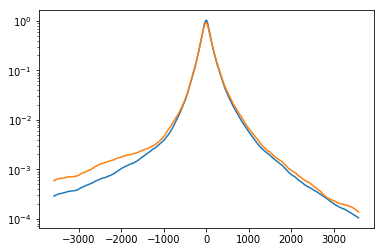

In [ ]:
# time and area averaged vertical density profile
dmean2_selected = (data_selected.loc['d']/data_selected.loc['A']).mean(axis=1)
plt.semilogy(z,dmean2)
plt.semilogy(z,dmean2_selected)

#### Example 3: Midplane Pressures

In [ ]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataarray(path) as ds:
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            print path
            ds.load()
            return ds

    datasets = [process_one_path(p) for p in files]
    combined = xr.concat(datasets, dim)
    return combined

# here we suppose we only care about the combined mean of each file;
# you might also use indexing operations like .sel to subset datasets
two_phase = read_netcdfs(zprof_fnames[:3], dim='phase').sum(dim='phase')

/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase1.zprof.nc
/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase2.zprof.nc


In [ ]:
two_phase

In [ ]:
zidx= np.abs(z) < 10
data_selected=two_phase[:,zidx,:]

In [ ]:
const=astropy.constants
tMyr=data_selected.taxis*units['time'].to('Myr').value
Pok_unit=(units['pressure']/const.k_B).cgs.value
Pth=(data_selected.loc['P']/data_selected.loc['A']).mean(axis=0)*Pok_unit

Pturb=(2.0*data_selected.loc['Ek3']/data_selected.loc['A']).mean(axis=0)*Pok_unit

oPmag=0.5*(data_selected.loc['B1']/data_selected.loc['A'])**2
oPmag+=0.5*(data_selected.loc['B2']/data_selected.loc['A'])**2
oPmag-=0.5*(data_selected.loc['B3']/data_selected.loc['A'])**2
oPmag=oPmag.mean(axis=0)*Pok_unit

tPmag=(data_selected.loc['dPB1']/data_selected.loc['A']).mean(axis=0)
tPmag+=(data_selected.loc['dPB2']/data_selected.loc['A']).mean(axis=0)
tPmag-=(data_selected.loc['dPB3']/data_selected.loc['A']).mean(axis=0)
tPmag=tPmag*Pok_unit

In [ ]:
plt.rcParams['font.size']=16
fig=plt.figure(figsize=(10,8))
plt.plot(tMyr,Pth,label=r'$P_{\rm th}$')
plt.plot(tMyr,Pturb,label=r'$P_{\rm turb}$')
plt.plot(tMyr,oPmag,label=r'$\overline{\Pi}_{\rm mag}$')
plt.plot(tMyr,tPmag,label=r'$\delta{\Pi}_{\rm mag}$')
lg=plt.legend()
plt.ylim(1.e2,1.e5)
plt.yscale('log')
plt.xlabel('t [Myr]')
plt.ylabel(r'$P/k_B [{\rm cm^{-3} K}]$')

In [ ]:
for label, P in zip(['thermal','turbulent','mean magnetic','turb. magnetic'],[Pth,Pturb,oPmag,tPmag]):
    print('{}/kB = {:8.2f}'.format(label, P[trange].data.mean()))